In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import bbknn
import os
from scipy import sparse

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/data/b_t_cells_tonsils_hk/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/lymph_nodes_analysis/'

reg_mod_name = 'RegressionNBV4Torch_57covariates_73260cells_10237genes'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'

adata = sc.read(f'{reg_path}sc.h5ad')
#r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
#reg_mod = r['mod']


sc.settings.figdir = f'{reg_path}plots/figures/'

In [4]:
#list(adata.obs['Subset'].value_counts().index)

In [5]:
adata.obs['Subset'].cat.reorder_categories([
'B_IFN',
'B_naive',
'B_activated',
'B_preGC',
'B_GC_LZ',
'B_GC_DZ',
'B_Cycling',
'B_GC_prePB',
'B_plasma',
'B_mem',    

'T_CD4+',
'T_CD4+_TfH',
'T_CD4+_TfH_GC',
'T_Treg',
'T_TfR',
'T_TIM3+',
'T_CD4+_naive',
'T_CD8+_naive',
'T_CD8+_cytotoxic',
'T_CD8+_CD161+',
'NKT',
'NK',
'ILC',
'DC_pDC',
'DC_cDC1',
'DC_cDC2',
'DC_CCR7+',
'Monocytes',
'Macrophages_M1',
'Macrophages_M2',
'Mast',
'Endo',
'FDC',
'VSMC'],inplace=True)

/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


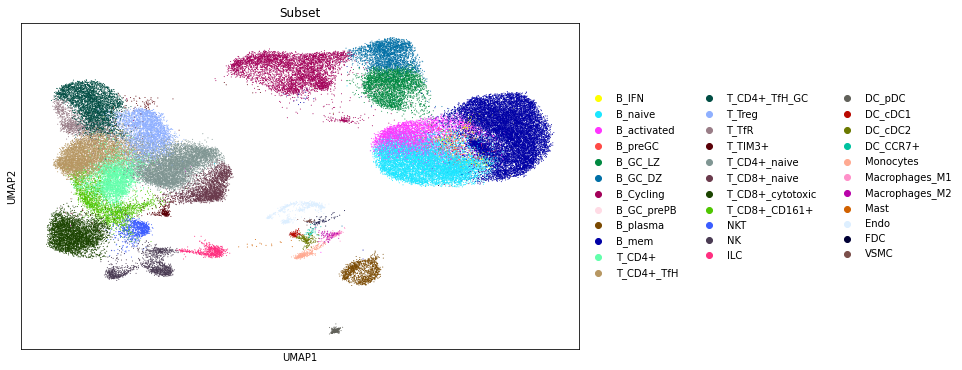

In [6]:
plt.rcParams['figure.figsize'] = [10, 6]
sc.pl.umap(adata, color=['Subset'], size=4)

## Identify marker genes

In [7]:
sc.tl.dendrogram(adata, groupby="Subset")

In [8]:
sc.tl.rank_genes_groups(adata, 'Subset')

/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:404: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


In [9]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,B_IFN,B_naive,B_activated,B_preGC,B_GC_LZ,B_GC_DZ,B_Cycling,B_GC_prePB,B_plasma,B_mem,...,DC_cDC1,DC_cDC2,DC_CCR7+,Monocytes,Macrophages_M1,Macrophages_M2,Mast,Endo,FDC,VSMC
0,HLA-DPB1,HLA-DRA,CD74,HLA-DRB1,MS4A1,SERF2,HMGB1,VPREB3,SSR4,HLA-DRA,...,LGALS2,TMSB10,TMSB10,TYROBP,AIF1,AIF1,KIT,IFITM3,FDCSP,CALD1
1,CD74,FCER2,CD83,MS4A1,HLA-DRB1,CD79B,GAPDH,LAPTM5,MZB1,BANK1,...,AIF1,HLA-DPB1,MARCKSL1,FTH1,LYZ,HCK,IL1RL1,GNG11,MDK,IGFBP7
2,HLA-DRA,HVCN1,HLA-DPA1,HLA-DQA1,LRMP,TCL1A,H2AFZ,CD79A,FKBP11,HLA-DPB1,...,SNX3,HLA-DPA1,GSTP1,AIF1,TMEM176B,BLVRB,HDC,EGFL7,CXCL13,IGFBP5
3,HLA-DPA1,HLA-DPB1,HLA-DRA,SYNGR2,CD74,NEIL1,HMGN2,MS4A1,FKBP2,HLA-DPA1,...,HLA-DPB1,HLA-DQA1,GPX4,S100A11,CAPG,NPC2,GATA2,PECAM1,CLU,VIM
4,LY6E,LINC00926,HLA-DQB1,FCER2,RGS13,ISG20,PPIA,HLA-DMA,PRDX4,HLA-DQB1,...,TMSB4X,HLA-DRB1,ZFAS1,CTSS,ATOX1,SLC40A1,FCER1G,ITM2B,DSP,SPARCL1


In [10]:
adata.uns['rank_genes_groups'].keys()

dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])

In [11]:
(pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj']) < 0.05).sum()

B_IFN               3772
B_naive             9610
B_activated         7988
B_preGC             5487
B_GC_LZ             8362
B_GC_DZ             8131
B_Cycling           9502
B_GC_prePB          3881
B_plasma            7098
B_mem               8354
T_CD4+              7646
T_CD4+_TfH          9036
T_CD4+_TfH_GC       7826
T_Treg              8183
T_TfR               5980
T_TIM3+             7795
T_CD4+_naive        9144
T_CD8+_naive        7524
T_CD8+_cytotoxic    8618
T_CD8+_CD161+       8279
NKT                 6350
NK                  6411
ILC                 6382
DC_pDC              5612
DC_cDC1             6705
DC_cDC2             6059
DC_CCR7+            3585
Monocytes           5807
Macrophages_M1      4408
Macrophages_M2      4052
Mast                6271
Endo                7885
FDC                 2216
VSMC                3284
dtype: int64

In [12]:
(pd.DataFrame(adata.uns['rank_genes_groups']['scores']) > 5).sum()

B_IFN                133
B_naive              387
B_activated          827
B_preGC              301
B_GC_LZ             3158
B_GC_DZ             2736
B_Cycling           6387
B_GC_prePB           140
B_plasma            1575
B_mem               1957
T_CD4+              1147
T_CD4+_TfH           583
T_CD4+_TfH_GC       1085
T_Treg               527
T_TfR                607
T_TIM3+             2201
T_CD4+_naive         569
T_CD8+_naive         681
T_CD8+_cytotoxic     627
T_CD8+_CD161+        563
NKT                  699
NK                  1227
ILC                  572
DC_pDC              1012
DC_cDC1               85
DC_cDC2             1375
DC_CCR7+               8
Monocytes           1053
Macrophages_M1       124
Macrophages_M2        97
Mast                   2
Endo                3088
FDC                   11
VSMC                  70
dtype: int64

In [13]:
(pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges']) >1).sum()

B_IFN                480
B_naive              122
B_activated          307
B_preGC              616
B_GC_LZ             1223
B_GC_DZ             1268
B_Cycling           4868
B_GC_prePB          2182
B_plasma            1454
B_mem                528
T_CD4+               541
T_CD4+_TfH           250
T_CD4+_TfH_GC        499
T_Treg               321
T_TfR                570
T_TIM3+             4294
T_CD4+_naive         255
T_CD8+_naive         399
T_CD8+_cytotoxic     320
T_CD8+_CD161+        374
NKT                  606
NK                   932
ILC                  925
DC_pDC              2304
DC_cDC1              526
DC_cDC2             4207
DC_CCR7+            1764
Monocytes           2125
Macrophages_M1      1366
Macrophages_M2      1340
Mast                 566
Endo                3762
FDC                 1845
VSMC                3366
dtype: int64

In [14]:
# export inferred averages in each cluster
inf_aver = adata.var.copy()
inf_aver = inf_aver.loc[:, ['mean_cov_effect_Subset_'  in i for i in inf_aver.columns]]
from re import sub
inf_aver.columns = [sub('mean_cov_effect_Subset_', '', i) for i in inf_aver.columns]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

In [15]:
# selecting most informative genes based on specificity
selection_specificity = 0.1

# normalise expression signatures:
cell_state_df_norm = (inf_aver.T / inf_aver.sum(1)).T
# apply cut off:
cell_state_df_norm = (cell_state_df_norm > selection_specificity)

# check the number of markers per cell type
pd.set_option('display.max_rows', int(inf_aver.shape[1]))
cell_state_df_norm.sum(0), (cell_state_df_norm.sum(1) > 0).sum(0), inf_aver.shape[0]

(B_Cycling           1799
 B_GC_DZ              271
 B_GC_LZ              230
 B_GC_prePB           397
 B_IFN                 76
 B_activated           31
 B_mem                 42
 B_naive               22
 B_plasma             482
 B_preGC               75
 DC_CCR7+             483
 DC_cDC1               87
 DC_cDC2              750
 DC_pDC               492
 Endo                1324
 FDC                  550
 ILC                  191
 Macrophages_M1       439
 Macrophages_M2       271
 Mast                 185
 Monocytes            403
 NK                   174
 NKT                   85
 T_CD4+                42
 T_CD4+_TfH            25
 T_CD4+_TfH_GC        119
 T_CD4+_naive          28
 T_CD8+_CD161+         37
 T_CD8+_cytotoxic      49
 T_CD8+_naive          45
 T_TIM3+              671
 T_TfR                135
 T_Treg                52
 VSMC                1342
 dtype: int64,
 6263,
 10237)

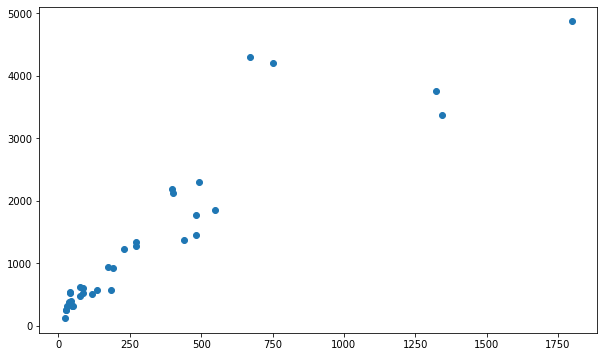

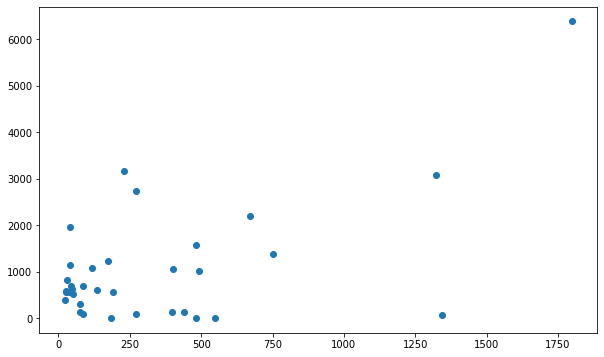

In [16]:
plt.scatter(cell_state_df_norm.sum(0),
           (pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges']) > 1).sum()[cell_state_df_norm.sum(0).index]);
plt.show()

plt.scatter(cell_state_df_norm.sum(0),
           (pd.DataFrame(adata.uns['rank_genes_groups']['scores']) > 5).sum()[cell_state_df_norm.sum(0).index]);
plt.show()

## All clusters - all top genes

/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


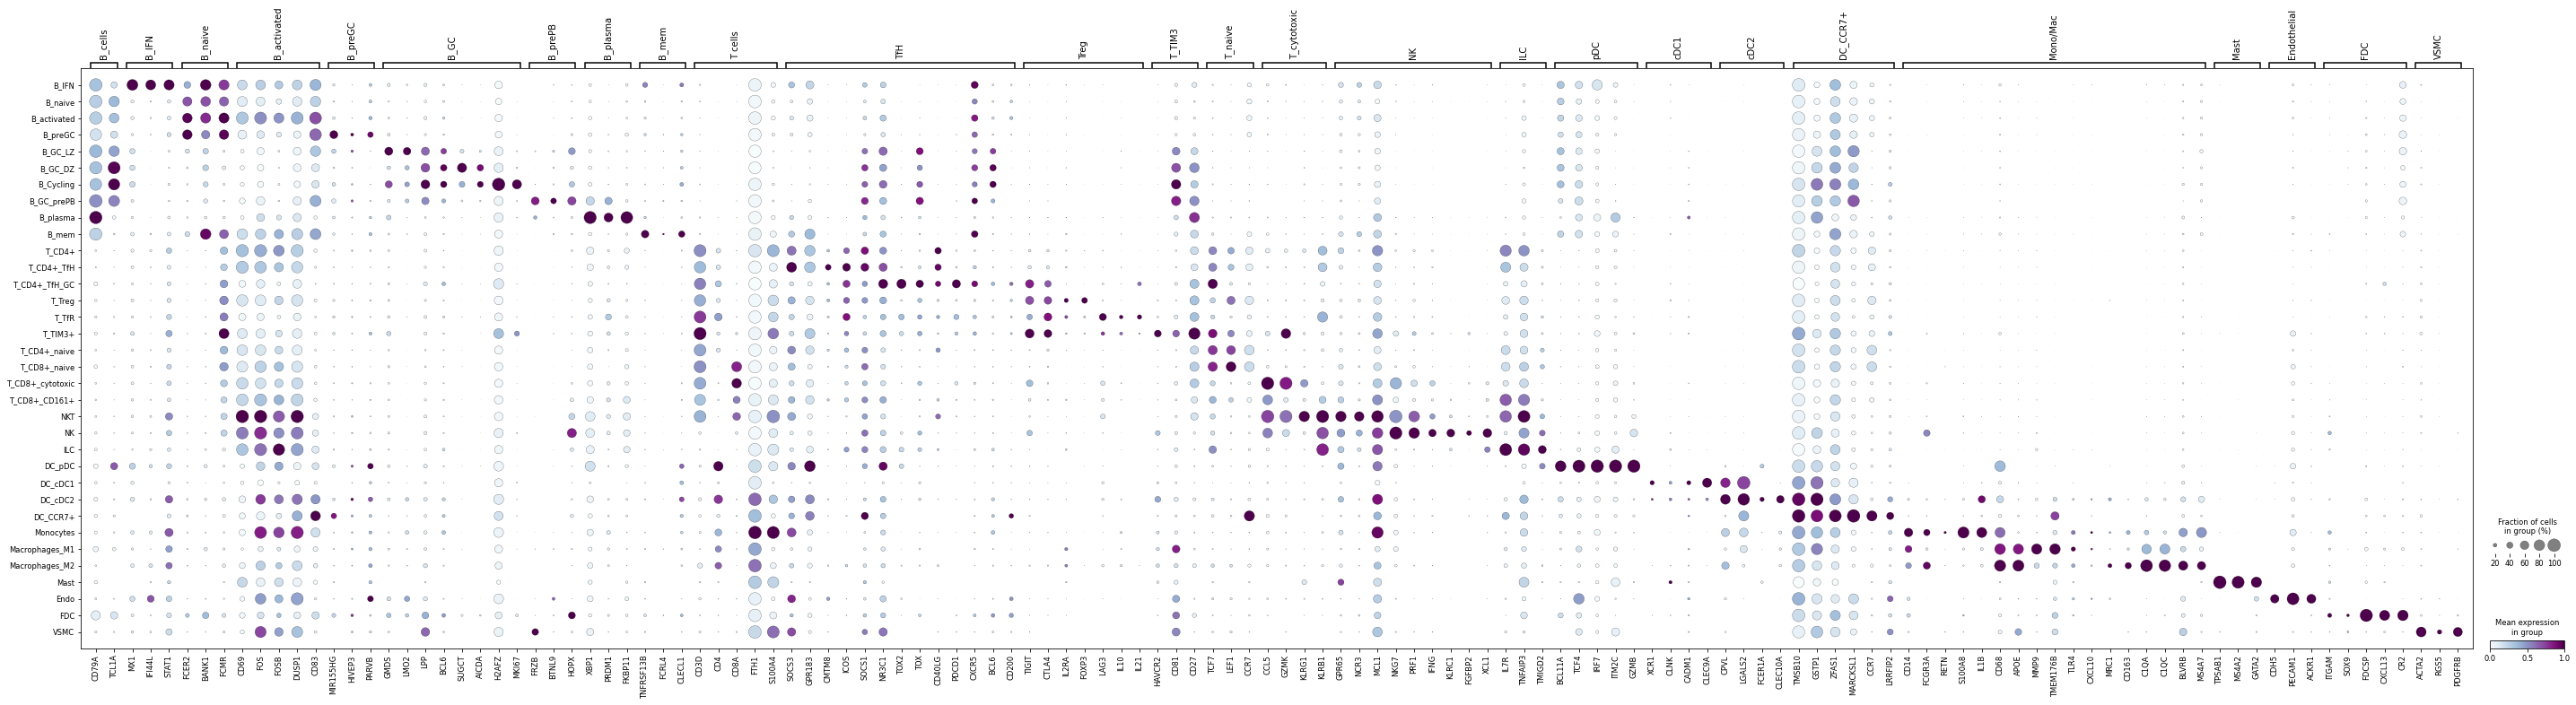

In [17]:
marker_genes_dict = {
    'B_cells': ["CD79A", "TCL1A"],
    'B_IFN': ["MX1","IFI44L", "STAT1"],
    'B_naive': ["FCER2", "BANK1", "FCMR"],
    'B_activated': ['CD69','FOS','FOSB','DUSP1','CD83'],
    'B_preGC': ["MIR155HG", "HIVEP3", "PARVB"],
    'B_GC': ["GMDS", "LMO2", "LPP", "BCL6", "SUGCT", "AICDA", "H2AFZ", "MKI67"],
    'B_prePB': ["FRZB", "BTNL9",  "HOPX"],
    'B_plasma': ["XBP1", "PRDM1",  "FKBP11"],
    'B_mem': ["TNFRSF13B", "FCRL4", "CLECL1"],

'T cells': ["CD3D",  "CD4", "CD8A", "FTH1", "S100A4"],
'TfH': ["SOCS3", "GPR183", "CMTM8","ICOS", "SOCS1", "NR3C1","TOX2", "TOX",
        "CD40LG", "PDCD1", "CXCR5", "BCL6", "CD200"],
'Treg': ["TIGIT", "CTLA4", "IL2RA","FOXP3", "LAG3", "IL10", "IL21"],
'T_TIM3': ["HAVCR2", "CD81", "CD27"],
'T_naive': ['TCF7', "LEF1", "CCR7"],
'T_cytotoxic': ["CCL5",'GZMK',  "KLRG1",  "KLRB1"],
'NK': ["GPR65","NCR3","MCL1", "NKG7","PRF1", "IFNG","KLRC1", "FGFBP2", "XCL1"],
'ILC': ["IL7R", "TNFAIP3",  "TMIGD2"],
'pDC': ["BCL11A",  "TCF4", "IRF7", "ITM2C", "GZMB"],    
'cDC1': ["XCR1", "CLNK", "CADM1", "CLEC9A"],
'cDC2': ['CPVL','LGALS2','FCER1A','CLEC10A',],
'DC_CCR7+': ["TMSB10",   "GSTP1", "ZFAS1", "MARCKSL1","CCR7",  "LRRFIP2"],    
'Mono/Mac': [
              'CD14',"FCGR3A", 'RETN','S100A8', "IL1B", #Mono
                "CD68",'APOE',                          #Mac
                'MMP9',"TMEM176B","TLR4","CXCL10",      #M1
    "MRC1", "CD163", 'C1QA',"C1QC", "BLVRB","MS4A7"     #M2
    ],
'Mast': ["TPSAB1",  "MS4A2","GATA2"],
'Endothelial': ["CDH5","PECAM1", "ACKR1"],
'FDC': ["ITGAM", "SOX9", "FDCSP", "CXCL13", "CR2"],    
'VSMC': ["ACTA2","RGS5", "PDGFRB"],
}

plt.rcParams['figure.figsize'] = [10, 3]
ax = sc.pl.dotplot(adata, marker_genes_dict, groupby='Subset', dendrogram=False, 
                   standard_scale='var', log=False, cmap="BuPu",
                   save='dotplot_all.pdf')

In [18]:
tcells = adata[adata.obs['Subset'].isin(['T_CD4+',
'T_CD4+_TfH',
'T_CD4+_TfH_GC',
'T_Treg',
'T_TfR',
'T_TIM3+',
'T_CD4+_naive',
    'T_CD8+_naive',
    'T_CD8+_cytotoxic',
'T_CD8+_CD161+',
'NKT',
'NK',
'ILC'])]

/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [19]:
bcells = adata[adata.obs['Subset'].isin(['B_IFN',
'B_naive',
'B_activated',
'B_preGC',
'B_GC_LZ',
'B_GC_DZ',
'B_Cycling',
'B_GC_prePB',
'B_plasma',
'B_mem'])]

In [20]:
nonlymphoidcells = adata[adata.obs['Subset'].isin(['DC_pDC',
'DC_cDC1',
'DC_cDC2',
'DC_CCR7+',
'Monocytes',
'Macrophages_M1',
'Macrophages_M2',
'Mast',
'Endo',
'FDC',
'VSMC'])]

/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


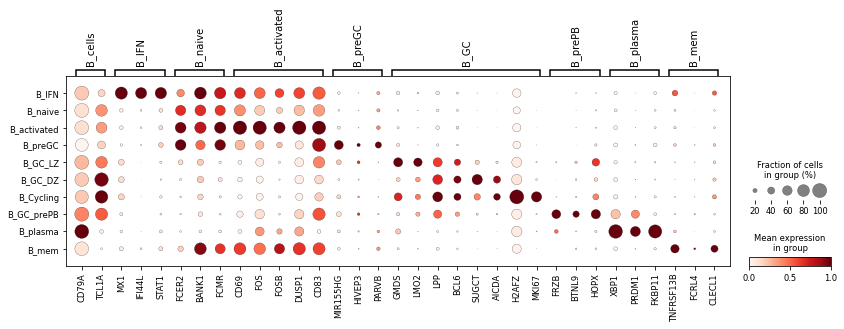

In [21]:
marker_genes_dict = {
    'B_cells': ["CD79A", "TCL1A"],
    'B_IFN': ["MX1","IFI44L", "STAT1"],
    'B_naive': ["FCER2", "BANK1", "FCMR"],
    'B_activated': ['CD69','FOS','FOSB','DUSP1','CD83'],
    'B_preGC': ["MIR155HG", "HIVEP3", "PARVB"],
    'B_GC': ["GMDS", "LMO2", "LPP", "BCL6", "SUGCT", "AICDA", "H2AFZ", "MKI67"],
    'B_prePB': ["FRZB", "BTNL9",  "HOPX"],
    'B_plasma': ["XBP1", "PRDM1",  "FKBP11"],
    'B_mem': ["TNFRSF13B", "FCRL4", "CLECL1"]
}

plt.rcParams['figure.figsize'] = [8.2, 3]
ax = sc.pl.dotplot(bcells, marker_genes_dict, groupby='Subset',
                   dendrogram=False, standard_scale='var', log=False, cmap="Reds",
                   save='dotplot_Bcells.pdf')

/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


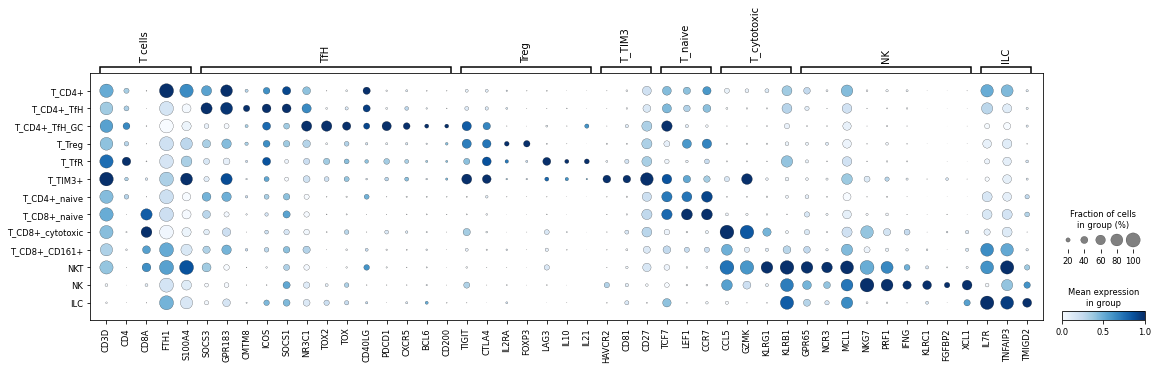

In [22]:
marker_genes_dict = {
'T cells': ["CD3D",  "CD4", "CD8A", "FTH1", "S100A4"],
'TfH': ["SOCS3", "GPR183", "CMTM8","ICOS", "SOCS1", "NR3C1","TOX2", "TOX",
        "CD40LG", "PDCD1", "CXCR5", "BCL6", "CD200"],
'Treg': ["TIGIT", "CTLA4", "IL2RA","FOXP3", "LAG3", "IL10", "IL21"],
'T_TIM3': ["HAVCR2", "CD81", "CD27"],
'T_naive': ['TCF7', "LEF1", "CCR7"],
'T_cytotoxic': ["CCL5",'GZMK',  "KLRG1",  "KLRB1"],
'NK': ["GPR65","NCR3","MCL1", "NKG7","PRF1", "IFNG","KLRC1", "FGFBP2", "XCL1"],
'ILC': ["IL7R", "TNFAIP3",  "TMIGD2"]
}

plt.rcParams['figure.figsize'] = [8.2, 3]
ax = sc.pl.dotplot(tcells, marker_genes_dict, groupby='Subset', 
                   dendrogram=False, standard_scale='var', log=False, cmap="Blues",
                   save='dotplot_Tcells.pdf')

/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


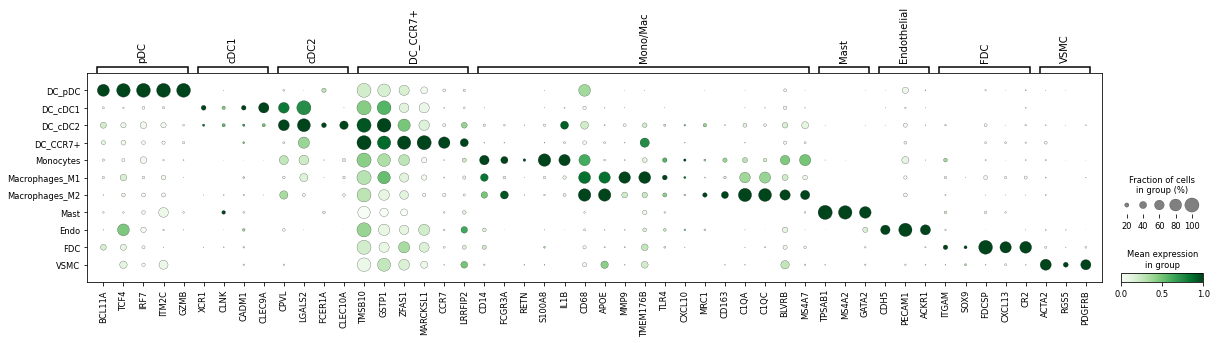

In [23]:
marker_genes_dict = {
    
'pDC': ["BCL11A",  "TCF4", "IRF7", "ITM2C", "GZMB"],    
'cDC1': ["XCR1", "CLNK", "CADM1", "CLEC9A"],
'cDC2': ['CPVL','LGALS2','FCER1A','CLEC10A',],
'DC_CCR7+': ["TMSB10",   "GSTP1", "ZFAS1", "MARCKSL1","CCR7",  "LRRFIP2"],    
'Mono/Mac': [
            'CD14',"FCGR3A", 'RETN','S100A8', "IL1B", #Mono
            "CD68",'APOE',                          #Mac
            'MMP9',"TMEM176B","TLR4","CXCL10",      #M1
            "MRC1", "CD163", 'C1QA',"C1QC", "BLVRB","MS4A7"     #M2
    ],
'Mast': ["TPSAB1",  "MS4A2","GATA2"],
'Endothelial': ["CDH5","PECAM1", "ACKR1"],
'FDC': ["ITGAM", "SOX9", "FDCSP", "CXCL13", "CR2"],    
'VSMC': ["ACTA2","RGS5", "PDGFRB"],
}

plt.rcParams['figure.figsize'] = [10, 3]
ax = sc.pl.dotplot(nonlymphoidcells, marker_genes_dict, groupby='Subset', 
                   dendrogram=False, standard_scale='var', log=False, cmap="Greens",
                   save='dotplot_other_cells.pdf')

# Only top 2/3 most important per cluster

/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


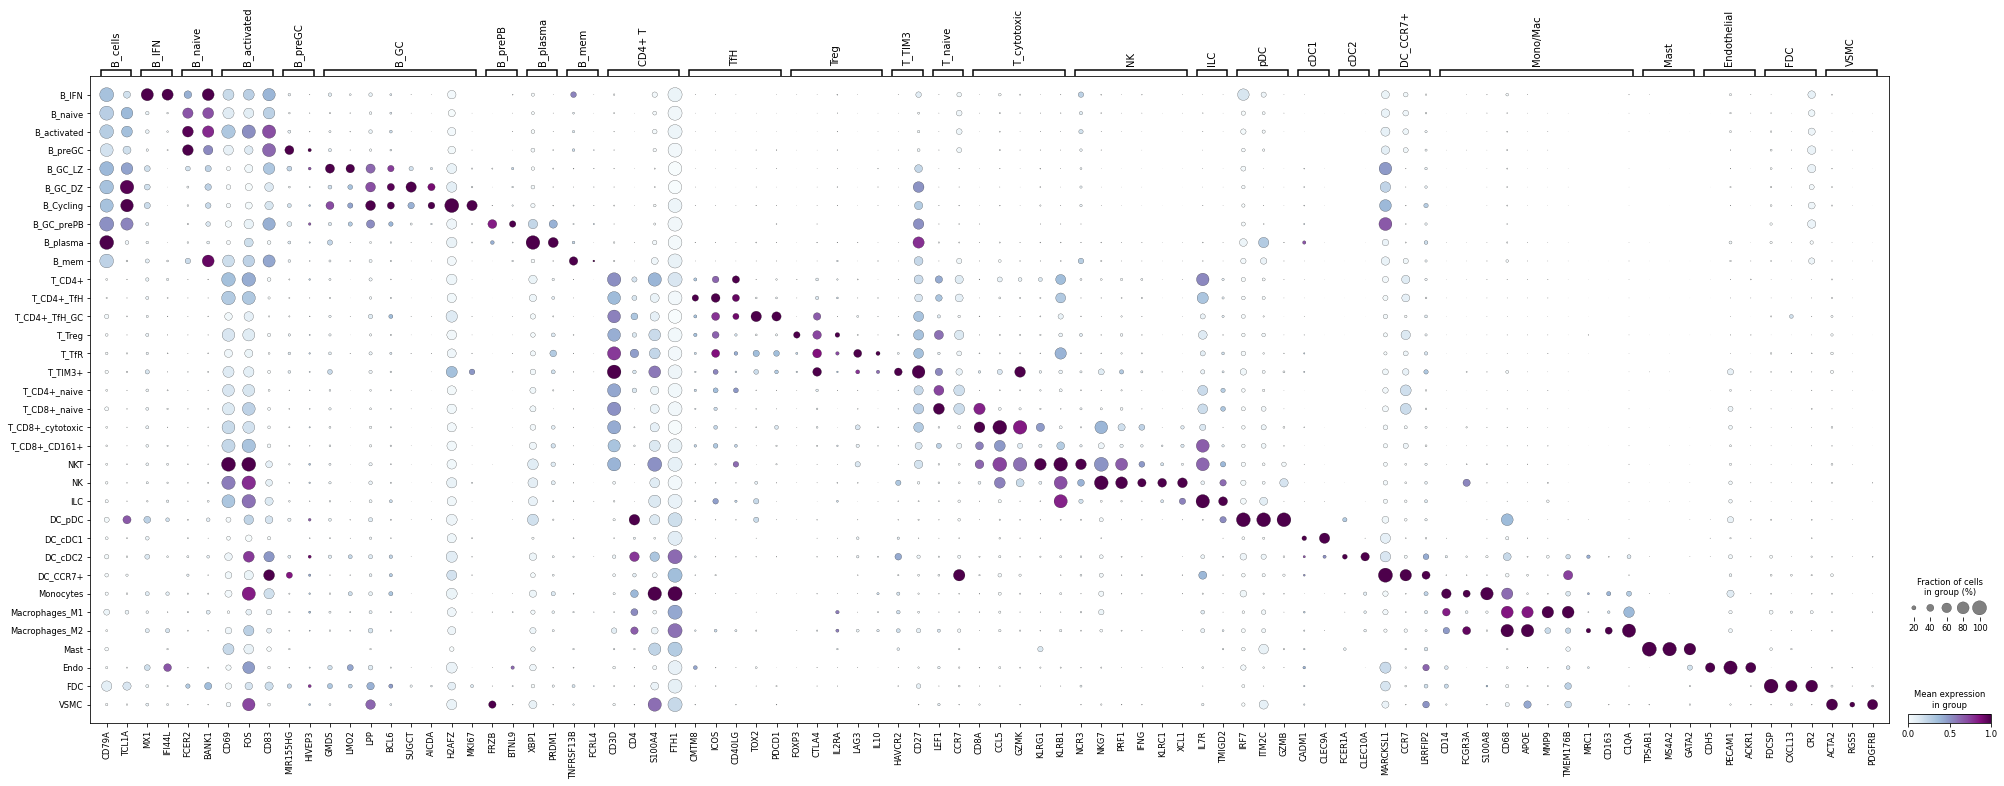

In [24]:
shortlist_marker_genes_dict = {
    'B_cells': ["CD79A", "TCL1A"],
    'B_IFN': ["MX1","IFI44L"],
    'B_naive': ["FCER2", "BANK1"],
    'B_activated': ['CD69','FOS','CD83'],
    'B_preGC': ["MIR155HG", "HIVEP3"],
    'B_GC': ["GMDS", "LMO2", 
             "LPP", "BCL6", 
             "SUGCT", "AICDA", 
             "H2AFZ", "MKI67"],
    'B_prePB': ["FRZB", "BTNL9"],
    'B_plasma': ["XBP1", "PRDM1"],
    'B_mem': ["TNFRSF13B", "FCRL4"],

'CD4+ T': ["CD3D",  "CD4",  
                 "S100A4", "FTH1"],
'TfH': ["CMTM8", "ICOS", "CD40LG","TOX2", "PDCD1"],
'Treg': ["FOXP3","CTLA4", "IL2RA", "LAG3", "IL10"],
'T_TIM3': ["HAVCR2", "CD27"],
'T_naive': ["LEF1", "CCR7"],
'T_cytotoxic': ["CD8A","CCL5",'GZMK',  "KLRG1",  "KLRB1"],
'NK': ["NCR3", "NKG7","PRF1", "IFNG","KLRC1", "XCL1"],
'ILC': ["IL7R", "TMIGD2"],
'pDC': ["IRF7", "ITM2C", "GZMB"],    
'cDC1': ["CADM1", "CLEC9A"],
'cDC2': ['FCER1A','CLEC10A'],
'DC_CCR7+': ["MARCKSL1","CCR7",  "LRRFIP2"],    
'Mono/Mac': [
              'CD14',"FCGR3A", 
                'S100A8', #Mono
                "CD68",'APOE',                          #Mac
                'MMP9',"TMEM176B",#M1
    "MRC1", "CD163", 'C1QA'#M2
    ],
'Mast': ["TPSAB1",  "MS4A2","GATA2"],
'Endothelial': ["CDH5","PECAM1", "ACKR1"],
'FDC': ["FDCSP", "CXCL13", "CR2"],    
'VSMC': ["ACTA2","RGS5", "PDGFRB"]
}

plt.rcParams['figure.figsize'] = [10, 3]
ax = sc.pl.dotplot(adata, shortlist_marker_genes_dict, groupby='Subset', 
                   dendrogram=False, standard_scale='var', log=False, cmap="BuPu",
                   save='dotplot_all_selected.pdf')

/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


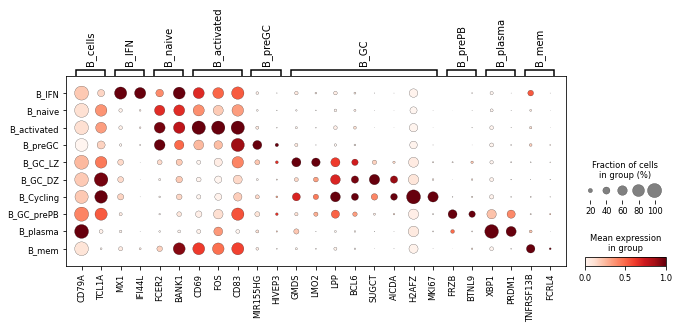

In [25]:
shortlist_marker_genes_dict = {
    'B_cells': ["CD79A", "TCL1A"],
    'B_IFN': ["MX1","IFI44L"],
    'B_naive': ["FCER2", "BANK1"],
    'B_activated': ['CD69','FOS','CD83'],
    'B_preGC': ["MIR155HG", "HIVEP3"],
    'B_GC': ["GMDS", "LMO2", 
             "LPP", "BCL6", 
             "SUGCT", "AICDA", 
             "H2AFZ", "MKI67"],
    'B_prePB': ["FRZB", "BTNL9"],
    'B_plasma': ["XBP1", "PRDM1"],
    'B_mem': ["TNFRSF13B", "FCRL4"],
}

plt.rcParams['figure.figsize'] = [10, 3]
ax = sc.pl.dotplot(bcells, shortlist_marker_genes_dict, groupby='Subset', dendrogram=False, standard_scale='var', log=False, cmap="Reds")

/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


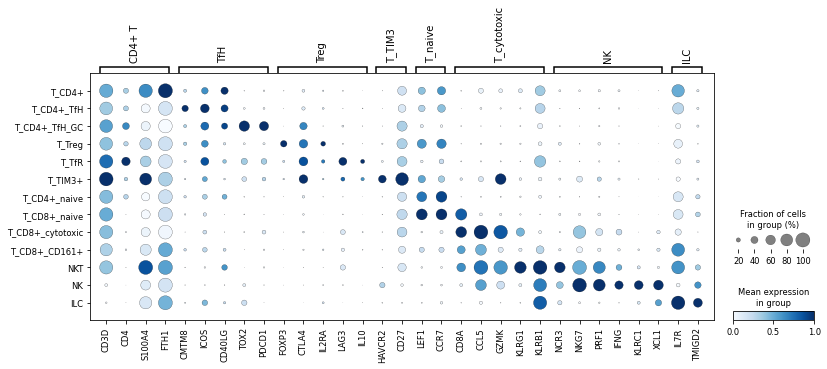

In [26]:
shortlist_marker_genes_dict = {
'CD4+ T': ["CD3D",  "CD4",  
                 "S100A4", "FTH1"],
'TfH': ["CMTM8", "ICOS", "CD40LG","TOX2", "PDCD1"],
'Treg': ["FOXP3","CTLA4", "IL2RA", "LAG3", "IL10"],
'T_TIM3': ["HAVCR2", "CD27"],
'T_naive': ["LEF1", "CCR7"],
'T_cytotoxic': ["CD8A","CCL5",'GZMK',  "KLRG1",  "KLRB1"],
'NK': ["NCR3", "NKG7","PRF1", "IFNG","KLRC1", "XCL1"],
'ILC': ["IL7R", "TMIGD2"],

}
plt.rcParams['figure.figsize'] = [10, 3]
ax = sc.pl.dotplot(tcells, shortlist_marker_genes_dict, groupby='Subset', dendrogram=False, standard_scale='var', log=False, cmap="Blues")

/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


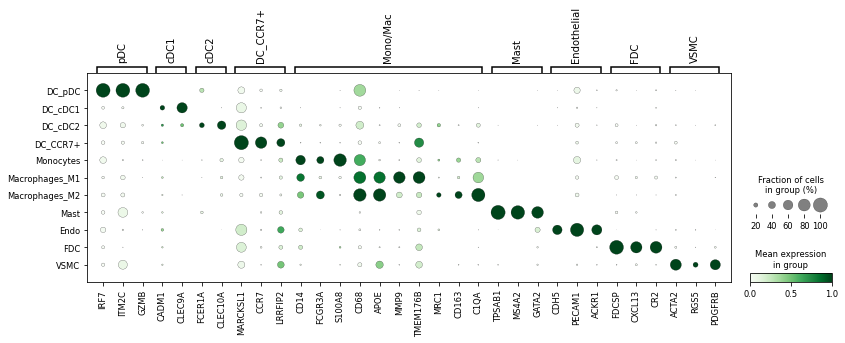

In [27]:
shortlist_marker_genes_dict = {
'pDC': ["IRF7", "ITM2C", "GZMB"],    
'cDC1': ["CADM1", "CLEC9A"],
'cDC2': ['FCER1A','CLEC10A'],
'DC_CCR7+': ["MARCKSL1","CCR7",  "LRRFIP2"],    
'Mono/Mac': [
              'CD14',"FCGR3A", 
                'S100A8', #Mono
                "CD68",'APOE',                          #Mac
                'MMP9',"TMEM176B",#M1
    "MRC1", "CD163", 'C1QA'#M2
    ],
'Mast': ["TPSAB1",  "MS4A2","GATA2"],
'Endothelial': ["CDH5","PECAM1", "ACKR1"],
'FDC': ["FDCSP", "CXCL13", "CR2"],    
'VSMC': ["ACTA2","RGS5", "PDGFRB"]
}

plt.rcParams['figure.figsize'] = [10, 3]
ax = sc.pl.dotplot(nonlymphoidcells, shortlist_marker_genes_dict, groupby='Subset', dendrogram=False, standard_scale='var', log=False, cmap="Greens")